<a href="https://colab.research.google.com/github/kravart87/neural_network_practice/blob/main/TransferLearning_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning и finetuning.

Цель данной работы  - научиться по фотографии лица человека предсказывать его пол, расу и возраст.

[Датасет](https://susanqq.github.io/UTKFace/), который будет использоваться состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет. В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)

В этом проекте мы возьмем за основу сеть, которая была обучена на датасете VGGFace2 для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями.


## Загрузка обученной модели.

Сеть, которую мы будем дообучать возьмем из открытого источника: https://github.com/DavidDoukhan/keras-vggface.

In [ ]:
! pip install git+https://github.com/DavidDoukhan/keras-vggface.git

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from keras_vggface.vggface import VGGFace

vggface_model = VGGFace(model='resnet50')

165445632/165439116 [==============================] - 15s 0us/step


In [ ]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

## Загрузка данных.


In [ ]:
! pip install gdown
import gdown

In [ ]:
from pathlib import Path
from collections import Counter

In [ ]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
100%|██████████| 107M/107M [00:01<00:00, 63.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 117MB/s]


'train_val_split_utk.csv'

In [ ]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['28_1_4_20170103182238570.jpg.chip.jpg', '37_1_0_20170117203545246.jpg.chip.jpg', '35_0_0_20170117170113915.jpg.chip.jpg']


In [ ]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg


,img_name,age,race,gender
0,36_0_4_20170104000906228.jpg.chip.jpg,0.310345,4,0
1,77_0_1_20170116210256280.jpg.chip.jpg,0.663793,1,0
2,26_0_1_20170116193350792.jpg.chip.jpg,0.224138,1,0
3,6_1_3_20161220222556995.jpg.chip.jpg,0.051724,3,1
4,85_1_0_20170110183346968.jpg.chip.jpg,0.732759,0,1


In [ ]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()

,is_train
img_name,
29_0_0_20170117180855986.jpg.chip.jpg,1
29_0_4_20170117202712541.jpg.chip.jpg,1
35_0_1_20170117104607288.jpg.chip.jpg,1
17_0_0_20170110231830374.jpg.chip.jpg,1
23_0_0_20170117194023317.jpg.chip.jpg,1


In [ ]:
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))

4759 18946


In [ ]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

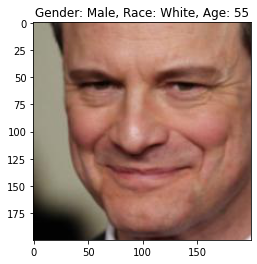

In [ ]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

## Создание генератора данных для модели предсказания пола.


###a) 
**Создание генератора image_gen типа ImageDataGenerator с корректным препроцессингом, соответствующем keras_vggface.** 

Т.к. эта модель не часть Keras, корректный препроцессинг можно найти с помощью исходников автора этой сети. Информация содержится в функции preprocess_input из utils.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface
    """

    preprocessed = np.copy(image_)
    data_format = K.image_data_format()
    if data_format == 'channels_first':
        preprocessed = preprocessed[:, ::-1, ...]
        preprocessed[:, 0, :, :] -= 91.4953
        preprocessed[:, 1, :, :] -= 103.8827
        preprocessed[:, 2, :, :] -= 131.0912
    else:
        preprocessed = preprocessed[..., ::-1]
        preprocessed[..., 0] -= 91.4953
        preprocessed[..., 1] -= 103.8827
        preprocessed[..., 2] -= 131.0912

    return preprocessed

image_gen = ImageDataGenerator(preprocessing_function = preprocess_input_facenet)


###b)
**Создание с использованием `image_gen.flow_from_dataframe` train_generator и val_generator для df_train и df_val соответственно.**





In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 128
IMAGE_SIZE = 224

train_generator = image_gen.flow_from_dataframe(df_train, directory = str(data_folder), x_col = 'img_name', y_col = 'gender', 
                                                target_size = (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE, class_mode = 'binary', shuffle = True)

val_generator = image_gen.flow_from_dataframe(df_val, directory = str(data_folder), x_col = 'img_name', y_col = 'gender', 
                                              target_size = (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE, class_mode = 'binary', shuffle = False)


Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.


Попробуем отобразить картинку и ее лейбл для проверки генерации:

Male


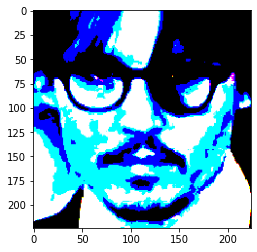

In [ ]:
sample_images, sample_labels = next(val_generator)
plt.imshow(sample_images[100])
print(gender_mapping[int(sample_labels[100])])

In [ ]:
print(sample_images[100].max(), sample_images[100].min()) # можно увидеть что значения яркостей типа float и в т.ч. отрицательные

163.5047 -131.0912


###с)
**Реализация функции `deprocess_image`, которая преобразует картинку исользуемую keras_vggface обратно к изображению, которое можно визуализировать с помощью `matplotlib`.**

Male


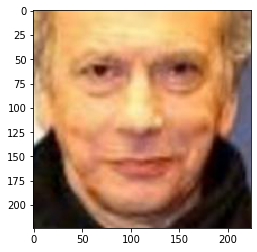

In [ ]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib.
    return: корректно отображаемая картинка.
    """

    image = np.copy(vggface_image)
    image[..., 0] += 91.4953
    image[..., 1] += 103.8827
    image[..., 2] += 131.0912  
    image = image[..., ::-1]
    image = image/255

    return image

plt.imshow(deprocess_image(sample_images[15]))
print(gender_mapping[int(sample_labels[15])])

##Обучение модели предсказания пола.

In [ ]:
# "отрежем" от vggface_model последний слой классификатора. 
# теперь для картинки base_model предсказывает 2048-мерный вектор признаков.

base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten").output)

base_model.trainable = False

model = tf.keras.Sequential([base_model, tf.keras.layers.Dense(1024, activation='sigmoid'), 
  tf.keras.layers.Dense(1024, activation='sigmoid'), tf.keras.layers.Dense(1, activation='sigmoid')])


model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0005), loss = 'binary_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 2048)              23561152  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 26,709,953
Trainable params: 3,148,801
Non-trainable params: 23,561,152
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

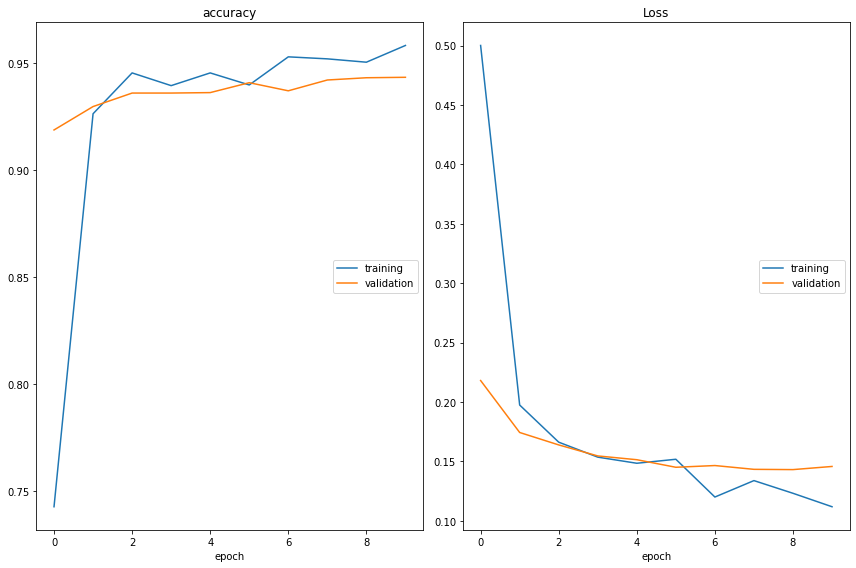

accuracy
	training         	 (min:    0.743, max:    0.958, cur:    0.958)
	validation       	 (min:    0.919, max:    0.943, cur:    0.943)
Loss
	training         	 (min:    0.112, max:    0.500, cur:    0.112)
	validation       	 (min:    0.143, max:    0.218, cur:    0.146)

Epoch 10: val_loss did not improve from 0.21811
25/25 [==============================] - 22s 903ms/step - loss: 0.1119 - accuracy: 0.9581 - val_loss: 0.1458 - val_accuracy: 0.9433


In [ ]:
path = Path('model_gender')
path.mkdir(exist_ok = True)
cpt_filename = "checkpoint_best.hdf5"
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')
history = model.fit_generator(train_generator, epochs = 10, steps_per_epoch = 25, validation_data = val_generator, callbacks=[PlotLossesCallback(), checkpoint])

In [ ]:
model_gender = tf.keras.models.load_model("/content/model_gender/checkpoint_best.hdf5")
loss, acc = model_gender.evaluate(val_generator)

38/38 [==============================] - 14s 341ms/step - loss: 0.2181 - accuracy: 0.9187


In [ ]:
#@title (вспомогательный код, визуализация результатов)
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

4/4 [==============================] - 2s 56ms/step


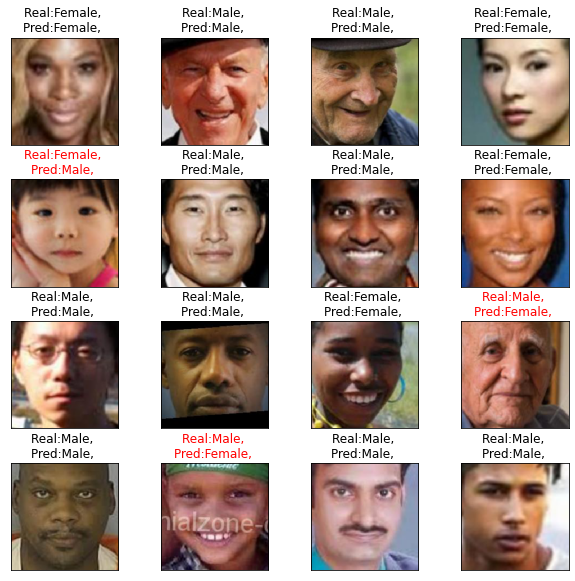

In [ ]:
sample_validation_images, sample_validation_labels = next(val_generator)
predicted = model_gender.predict(sample_validation_images)
show_faces(sample_validation_images, real_gender=sample_validation_labels, predicted_gender=predicted)

##Обучение модели предсказания расы.



In [ ]:
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten").output)
base_model.trainable = False

In [ ]:
train_race_generator = image_gen.flow_from_dataframe(df_train, directory = str(data_folder), x_col = 'img_name', y_col = 'race', 
                                                target_size = (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE, class_mode = 'sparse', shuffle = True)


val_race_generator = image_gen.flow_from_dataframe(df_val, directory = str(data_folder), x_col = 'img_name', y_col = 'race', 
                                              target_size = (IMAGE_SIZE, IMAGE_SIZE), batch_size = BATCH_SIZE, class_mode = 'sparse', shuffle = False)

Found 18946 validated image filenames belonging to 5 classes.
Found 4759 validated image filenames belonging to 5 classes.


Black


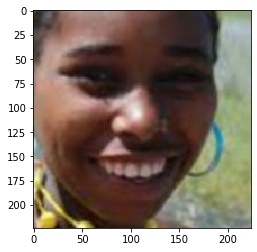

In [ ]:
sample_images, sample_labels = next(val_race_generator)
plt.imshow(deprocess_image(sample_images[10]))
print(race_mapping[int(sample_labels[10])])

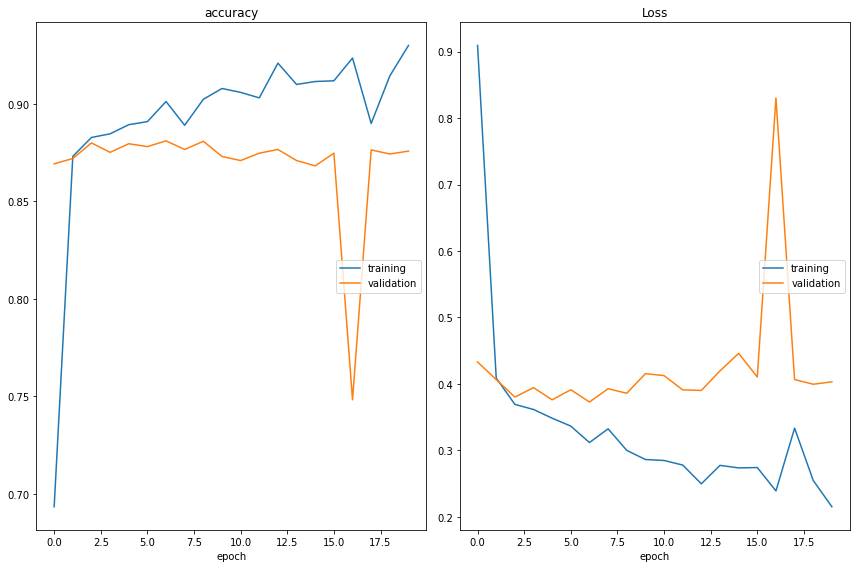

accuracy
	training         	 (min:    0.693, max:    0.930, cur:    0.930)
	validation       	 (min:    0.748, max:    0.881, cur:    0.876)
Loss
	training         	 (min:    0.215, max:    0.909, cur:    0.215)
	validation       	 (min:    0.373, max:    0.830, cur:    0.403)

Epoch 20: val_loss did not improve from 0.83029
25/25 [==============================] - 23s 942ms/step - loss: 0.2153 - accuracy: 0.9300 - val_loss: 0.4032 - val_accuracy: 0.8758


In [ ]:
model = tf.keras.Sequential([base_model, tf.keras.layers.Dense(1024, activation='sigmoid'), 
  tf.keras.layers.Dense(1024, activation='sigmoid'), tf.keras.layers.Dense(5, activation='softmax')])


model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.0005), # уменьшили скорость обучения
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

path = Path('model_race')
path.mkdir(exist_ok = True)
cpt_filename = "checkpoint_best.hdf5"
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'max')
history = model.fit_generator(train_race_generator, epochs = 20, steps_per_epoch = 25, validation_data = val_race_generator, callbacks=[PlotLossesCallback(), checkpoint])

In [ ]:
model_race = tf.keras.models.load_model("/content/model_race/checkpoint_best.hdf5")
loss, acc = model_race.evaluate(val_race_generator)

38/38 [==============================] - 15s 359ms/step - loss: 0.8303 - accuracy: 0.7483


4/4 [==============================] - 1s 95ms/step


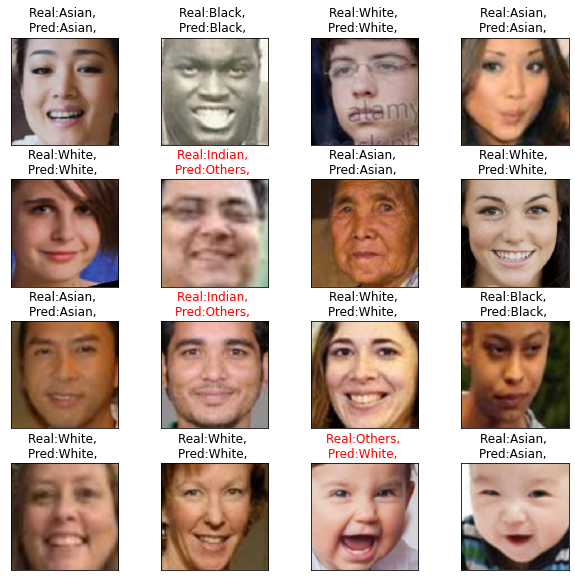

In [ ]:
sample_validation_images, sample_validation_labels = next(val_race_generator)
predicted = model_race.predict(sample_validation_images)
show_faces(sample_validation_images, real_race=sample_validation_labels, predicted_race=predicted)

## Multitask learning. Модель для предсказания каждого атрибута (возраст, раса, пол).



In [ ]:
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten").output)
base_model.trainable = False

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_3 (Functional)           (None, 2048)         23561152    ['input_3[0][0]']                
                                                                                                  
 Layer1 (Dense)                 (None, 512)          1049088     ['model_3[0][0]']                
                                                                                                  
 Layer2 (Dense)                 (None, 512)          262656      ['Layer1[0][0]']           

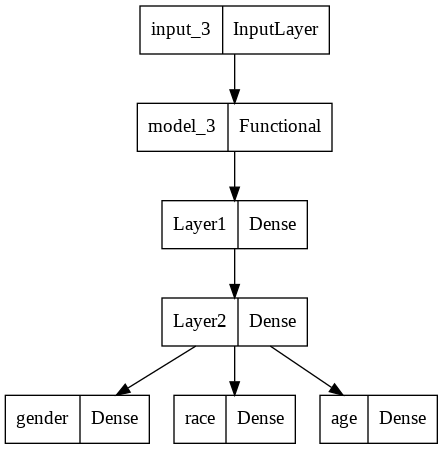

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense

input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_output = base_model(input_layer)
l1_output = Dense(512, name = 'Layer1', activation = 'sigmoid')(base_output)
l2_output = Dense(512, name = 'Layer2', activation = 'sigmoid')(l1_output)
gender_output = Dense(1, name = 'gender', activation = 'sigmoid')(l2_output)
race_output = Dense(5, name = 'race', activation = 'softmax')(l2_output)
age_output = Dense(1, name = 'age')(l2_output)
model = tf.keras.Model(inputs = input_layer, outputs = [gender_output, race_output, age_output])

model.summary()
plot_model(model)


In [ ]:
df_train['race'] = np.asarray(df_train['race']).astype(np.float32)
df_train['gender'] = np.asarray(df_train['gender']).astype(np.float32)
df_val['race'] = np.asarray(df_val['race']).astype(np.float32)
df_val['gender'] = np.asarray(df_val['gender']).astype(np.float32)

In [ ]:
train_generator = image_gen.flow_from_dataframe(
        dataframe = df_train,
        class_mode = 'other',
        x_col = 'img_name', y_col= ['gender', 'race', 'age'], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe = df_val,
        class_mode = 'other',
        x_col = 'img_name', y_col = ['gender', 'race', 'age'], 
        directory = str(data_folder),
        target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size = BATCH_SIZE,
        shuffle = False)

def split_outputs(generator):
    '''
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех 'задач')
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.
    '''
    
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1], 3, axis=1)
        yield image, labels

Found 18946 validated image filenames.
Found 4759 validated image filenames.


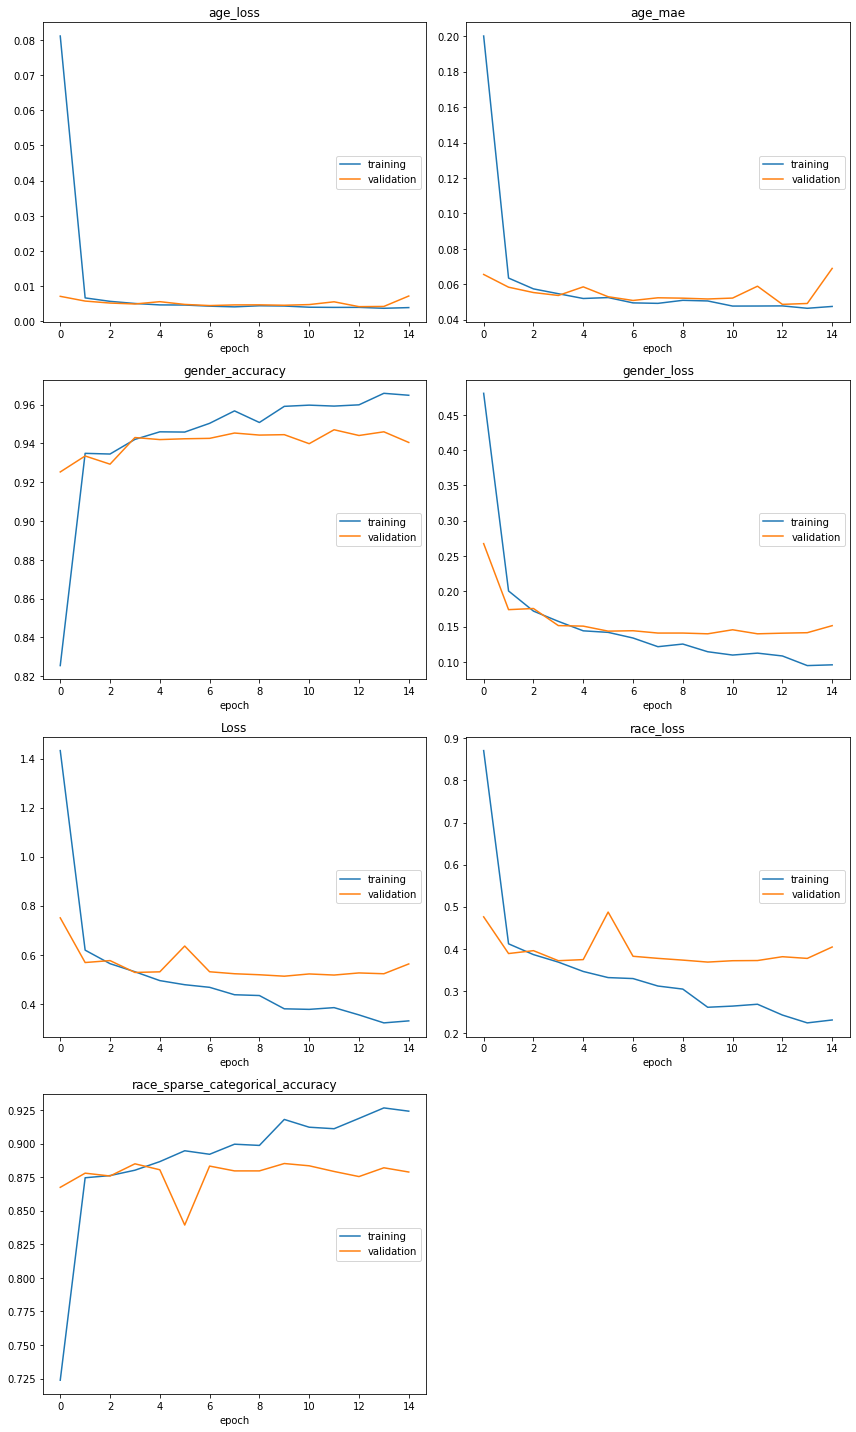

age_loss
	training         	 (min:    0.004, max:    0.081, cur:    0.004)
	validation       	 (min:    0.004, max:    0.007, cur:    0.007)
age_mae
	training         	 (min:    0.046, max:    0.200, cur:    0.047)
	validation       	 (min:    0.049, max:    0.069, cur:    0.069)
gender_accuracy
	training         	 (min:    0.825, max:    0.966, cur:    0.965)
	validation       	 (min:    0.925, max:    0.947, cur:    0.940)
gender_loss
	training         	 (min:    0.095, max:    0.480, cur:    0.096)
	validation       	 (min:    0.140, max:    0.267, cur:    0.151)
Loss
	training         	 (min:    0.322, max:    1.432, cur:    0.330)
	validation       	 (min:    0.512, max:    0.750, cur:    0.562)
race_loss
	training         	 (min:    0.224, max:    0.871, cur:    0.231)
	validation       	 (min:    0.368, max:    0.487, cur:    0.404)
race_sparse_categorical_accuracy
	training         	 (min:    0.724, max:    0.927, cur:    0.924)
	validation       	 (min:    0.839, max:    0.885

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005) 

# теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics
model.compile(optimizer=optimizer, 
              loss = {'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics = {'gender': 'accuracy', 'race': 'sparse_categorical_accuracy', 'age': 'mae'})

path = Path('model_multitask')
path.mkdir(exist_ok = True)
cpt_filename = 'checkpoint_best.h5'
cpt_path = str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor = 'val_age_mae', verbose=1, save_best_only = True, mode = 'min')

model.fit_generator(split_outputs(train_generator), epochs = 15, validation_data = split_outputs(val_generator),
                    callbacks = [PlotLossesCallback(), checkpoint], steps_per_epoch = 50, 
                    validation_steps = len(df_val) // BATCH_SIZE)


In [ ]:
model_multitask = tf.keras.models.load_model('model_multitask/checkpoint_best.h5')
val_generator = image_gen.flow_from_dataframe(
        dataframe = df_val, class_mode = 'other',
        x_col = 'img_name', y_col = ['gender', 'race', 'age'], 
        directory=str(data_folder), target_size = (IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE, shuffle = True)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
results

Found 4759 validated image filenames.
37/37 [==============================] - 13s 361ms/step - loss: 0.5590 - gender_loss: 0.1507 - race_loss: 0.4011 - age_loss: 0.0072 - gender_accuracy: 0.9407 - race_sparse_categorical_accuracy: 0.8794 - age_mae: 0.0690


[0.5589909553527832,
 0.15069343149662018,
 0.4011066257953644,
 0.007190847769379616,
 0.9406672120094299,
 0.8794341087341309,
 0.06896617263555527]

4/4 [==============================] - 1s 91ms/step


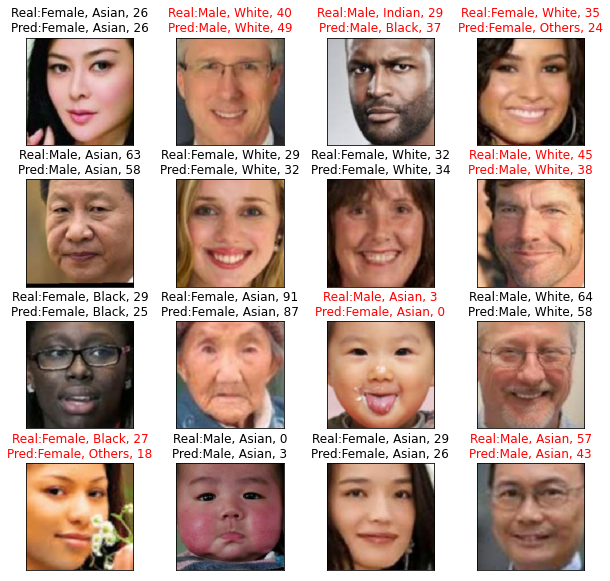

In [ ]:
model_multitask = tf.keras.models.load_model('/content/model_multitask/checkpoint_best.h5')
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels[0], predicted_gender=predicted[0],
           real_race=sample_validation_labels[1], predicted_race=predicted[1],
           real_age=sample_validation_labels[2].flatten(), predicted_age=predicted[2].flatten(),
           )